In [ ]:
# Imports
import torch
import numpy as np
from PIL import Image
import os, re, random
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from transformers import AutoImageProcessor, AutoModel
import csv
from pathlib import Path

# Settings
SEED = 1
BATCH_SIZE = 32
TOP_K = 10
MODEL_ID = "facebook/dinov3-vit7b16-pretrain-lvd1689m"  # change to desired HF model id (e.g., dinov2 or dinov3)
IMAGES_ROOT = "petface/dog"  # root directory for images
TEST_GALLERY = "splits_petface_test_10k/test_gallery.csv"
TEST_QUERY = "splits_petface_test_10k/test_query.csv"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
# ----------
# Loading
# ----------

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load DINOv2 from Hugging Face
processor = AutoImageProcessor.from_pretrained(MODEL_ID, use_fast=True)
model = AutoModel.from_pretrained(MODEL_ID).to(device)
model.eval()
print("Loaded Hugging Face model:", MODEL_ID)


# Load images and labels from CSV splits
def load_images_from_split(csv_path):
    img_paths = []
    labels = []
    root = Path(IMAGES_ROOT)
    with open(csv_path, "r", newline="") as f:
        reader = csv.DictReader(f)
        # Expecting columns: img_rel_path, pid
        for row in reader:
            rel = row.get("img_rel_path")
            pid = row.get("pid")
            if rel is None or pid is None:
                # Skip malformed rows
                continue
            full = root / rel
            img_paths.append(str(full))
            # Try converting pid to int; if that fails, try to infer from path components
            try:
                labels.append(int(pid))
            except Exception:
                inferred = None
                try:
                    m = re.search(r"(\d+)", rel)
                    if m:
                        inferred = int(m.group(1))
                except Exception:
                    inferred = None
                labels.append(inferred if inferred is not None else -1)
    return img_paths, labels


gallery_paths, gallery_labels = load_images_from_split(TEST_GALLERY)
query_paths, query_labels = load_images_from_split(TEST_QUERY)
print(
    f"Total gallery images: {len(gallery_paths)}, Total query images: {len(query_paths)}"
)

Using device: cuda


Loading checkpoint shards: 100%|██████████| 6/6 [00:00<00:00, 68.89it/s]



Loaded Hugging Face model: facebook/dinov3-vit7b16-pretrain-lvd1689m
Total gallery images: 20590, Total query images: 10000


In [3]:
# ----------
# Inference
# ----------


# Extract features (embeddings) using DINO
@torch.no_grad()
def extract_features(img_paths):
    feats = []
    valid_indices = []
    for i in tqdm(range(0, len(img_paths), BATCH_SIZE), desc="Extracting (HF)"):
        batch_paths = img_paths[i : i + BATCH_SIZE]
        images = []
        batch_valid_idxs = []
        # Load and preprocess images
        for j, p in enumerate(batch_paths):
            try:
                images.append(Image.open(p).convert("RGB"))
                batch_valid_idxs.append(i + j)  # global index
            except Exception as e:
                print(f"Warning: failed to open {p}: {e}")
        if len(images) == 0:
            continue
        # Model inference
        inputs = processor(images=images, return_tensors="pt")
        x = inputs["pixel_values"].to(device)
        out = model(x)
        # Extract features from model output
        if hasattr(out, "pooler_output") and out.pooler_output is not None:
            feat = out.pooler_output
        elif hasattr(out, "last_hidden_state"):
            feat = out.last_hidden_state[:, 0, :]
        elif isinstance(out, torch.Tensor):
            feat = out
        else:
            raise RuntimeError("Unrecognized HF model output structure; inspect `out`")
        # Normalisation
        norm = feat.norm(dim=-1, keepdim=True).clamp_min(1e-12)
        feat = feat / norm
        feats.append(feat.cpu().numpy())
        valid_indices.extend(batch_valid_idxs)

    if len(feats) == 0:
        return np.zeros((0, 0), dtype=np.float32), []
    return np.vstack(feats).astype(np.float32), valid_indices


print("Extracting query features...")
query_feats, q_valid_idx = extract_features(query_paths)
print("Extracting gallery features...")
gallery_feats, g_valid_idx = extract_features(gallery_paths)

# Filter labels and paths to only the successfully-loaded images for alignment
query_labels = [query_labels[i] for i in q_valid_idx]
query_paths = [query_paths[i] for i in q_valid_idx]
gallery_labels = [gallery_labels[i] for i in g_valid_idx]
gallery_paths = [gallery_paths[i] for i in g_valid_idx]

Extracting query features...


Extracting (HF): 100%|██████████| 313/313 [33:07<00:00,  6.35s/it]



Extracting gallery features...


Extracting (HF): 100%|██████████| 644/644 [1:08:06<00:00,  6.35s/it]


100%|██████████| 10000/10000 [00:57<00:00, 175.06it/s]



Top-1 Accuracy: 0.7838
Top-5 Accuracy: 0.8709
Top-10 Accuracy: 0.8972
mAP: 0.7395
mAP: 0.7395


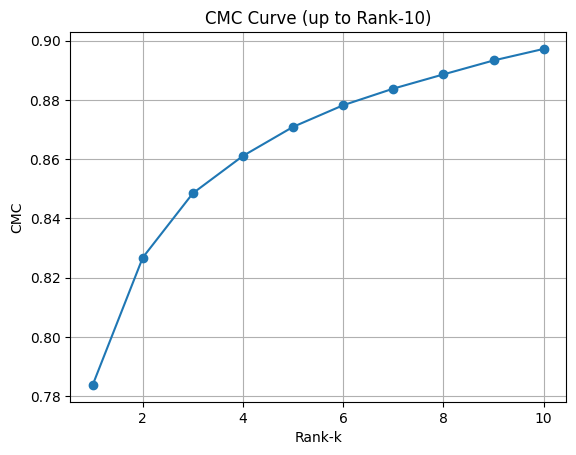

In [5]:
# ----------
# Evaluation
# ----------

# Calculate and sort by cosine similarity
pred_labels_topk = []
pred_labels_top1 = []

# Iterate over valid query features by index to keep alignment after filtering
for q_idx in tqdm(range(len(query_feats)), total=len(query_feats)):
    q_feat = query_feats[q_idx]
    true_label = query_labels[q_idx]
    sims = np.dot(gallery_feats, q_feat)
    # Mask exact same image path in gallery to avoid trivial self-match
    q_path = query_paths[q_idx]
    for gi, gpath in enumerate(gallery_paths):
        if gpath == q_path:
            sims[gi] = -np.inf
    # Get top-k indices (handle small gallery safely)
    topk_idx = np.argsort(sims)[-min(TOP_K, len(sims)) :][::-1]
    topk_labels = [gallery_labels[idx] for idx in topk_idx]
    pred_labels_topk.append(topk_labels)
    pred_labels_top1.append(topk_labels[0] if len(topk_labels) > 0 else -1)

# Top1 / Top5 / Top10
top1_acc = np.mean(
    [q == (p[0] if p else -1) for q, p in zip(query_labels, pred_labels_topk)]
)
top5_acc = np.mean(
    [q in (p[:5] if p else []) for q, p in zip(query_labels, pred_labels_topk)]
)
top10_acc = np.mean(
    [q in (p[:10] if p else []) for q, p in zip(query_labels, pred_labels_topk)]
)
print(f"Top-1 Accuracy: {top1_acc:.4f}")
print(f"Top-5 Accuracy: {top5_acc:.4f}")
print(f"Top-10 Accuracy: {top10_acc:.4f}")

# mAP
aps = []
for q_label, preds in zip(query_labels, pred_labels_topk):
    # Find all positions where the prediction matches the query label
    hits = [i for i, p in enumerate(preds[:TOP_K]) if p == q_label]
    num_rel = sum([g == q_label for g in gallery_labels])
    if num_rel == 0 or len(hits) == 0:
        aps.append(0.0)
        continue
    precisions = []
    for hit_idx in hits:
        # Precision at each correct hit (1-based rank)
        precisions.append(
            sum([preds[j] == q_label for j in range(hit_idx + 1)]) / (hit_idx + 1)
        )
    # Average precision for this query: mean over all correct hits, normalized by number of relevant items in gallery
    ap = np.sum(precisions) / min(num_rel, TOP_K)
    aps.append(ap)
mAP = np.mean(aps) if len(aps) > 0 else 0.0
print(f"mAP: {mAP:.4f}")

# CMC Curve
max_rank = 10
cmc = np.zeros(max_rank)
valid_q_mask = [lbl != -1 for lbl in query_labels]
valid_q_count = sum(valid_q_mask)
for q_idx, true_label in enumerate(query_labels):
    if true_label == -1:
        continue
    preds = pred_labels_topk[q_idx]
    ranked_labels = preds[:max_rank] + [-1] * max(0, max_rank - len(preds))
    for r in range(max_rank):
        if true_label in ranked_labels[: r + 1]:
            cmc[r:] += 1
            break
cmc = cmc / max(1, valid_q_count)
plt.figure()
plt.plot(range(1, max_rank + 1), cmc, marker="o")
plt.xlabel("Rank-k")
plt.ylabel("CMC")
plt.title("CMC Curve (up to Rank-10)")
plt.grid()
plt.show()